In [202]:
import numpy as np
import os.path
import pickle
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower, CAMBError
from scipy.interpolate import interpn,interp1d,LinearNDInterpolator
import corner
import emcee
import math
import matplotlib as mpl
from astropy.cosmology import w0waCDM

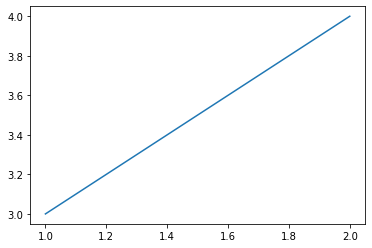

In [3]:
# importing from getdist on Perlmutter seems to break pyplot for me unless I do this weird thing

plt.plot([1,2],[3,4]);
plt.show()

In [4]:
from getdist import plots, MCSamples

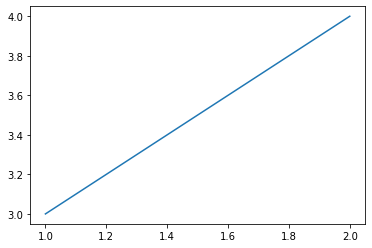

In [5]:
plt.plot([1,2],[3,4]);
plt.show()

In [6]:
mpl.rcParams.update({'font.size':22})

In [29]:
# Set the middle of the redshift bins for the entire notebook
z_list = np.array([0.25]) #original value of 0.25 provided in notebook for sample data, .116 for abacus vollim
z_list[::-1].sort() #sortt by decreasing reshift for use with CAMB
# run_ID variable that groups everything into a folder
run_ID = "wCDM"
os.makedirs("./"+run_ID, exist_ok=True)

In [8]:
# initial and base cosmologies

Kos = camb.CAMBparams();
h = 0.6781
Kos.set_cosmology(H0=h*100);
Kos0 = camb.CAMBparams();
Kos0.set_cosmology(H0=h*100);

Kos.omch2 = Kos0.omch2*.315/Kos0.omegam
Kos.ombh2 = Kos0.ombh2*.315/Kos0.omegam
Kos.omnuh2 = Kos0.omnuh2*.315/Kos0.omegam
Kos.DarkEnergy.set_params(w=-1,wa=0)
Kos.set_matter_power(redshifts=[0], kmax=2.0)
results = camb.get_results(Kos)

In [203]:
#set up VSS bins for interpolation grid

#radii are on range (r_low, r_high) with r_nbins bins
r_low=10
r_high=70
r_nbins = 60
r_hbw = (r_high-r_low)/(2*r_nbins)
#fidcial radii
r_fid = np.expand_dims(np.linspace(r_low,r_high,r_nbins +1)[:-1] + r_hbw,axis=0)
print(r_fid)

[[10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5
  24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5
  38.5 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5
  52.5 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5
  66.5 67.5 68.5 69.5]]


In [11]:
# void size spectrum function
h = 0.6781
Kos2 = w0waCDM(H0=67.81,Om0=0.315,Ode0=0.685,w0=-1.,wa=0.)
def theory_size_spectrum(delta,Om_m,w0,wa,w,z,beff,vol_norm = 1e9):
    #create cosmology
    Kos = camb.CAMBparams();
    Kos.set_cosmology(H0=h*100);
    dnlv = delta/beff
    #set Om and DEoS in cosmology
    Kos.omch2 = Kos0.omch2*Om_m/Kos0.omegam
    Kos.ombh2 = Kos0.ombh2*Om_m/Kos0.omegam
    Kos.omnuh2 = Kos0.omnuh2*Om_m/Kos0.omegam
    Kos.DarkEnergy.set_params(w=w0,wa=wa)
    #get results for calculating sigma_R
    Kos.set_matter_power(redshifts=z, kmax=2.0)
    results = camb.get_results(Kos)
    # fiducial cosmology, accoutns for change in survey volume
    h2   = Kos2.H(z).value
    a2   = Kos2.angular_diameter_distance(z).value
    # same as first cosmology KOS but with astropy
    Kos3 = w0waCDM(H0=67.81,Om0=Om_m,Ode0=1.-Om_m,w0=w0,wa=wa)
    h3   = Kos3.H(z).value
    a3   = Kos3.angular_diameter_distance(z).value
    agr = np.expand_dims( ((h2/h3)**(1./3))*((a3/a2)**(2./3)) , axis=1)
    #non-cumulative vss
    radii = np.repeat(r_fid,len(z),axis=0)
    dN = dndln((radii)/agr,w,dnlv,results) * (np.log(radii+r_hbw)-np.log(radii-r_hbw))
    
    #get sigma 8
    Kos.set_matter_power(redshifts=[0], kmax=2.0)
    results = camb.get_results(Kos)
    
    return results.get_sigma8_0(), vol_norm * ( np.cumsum( dN [:,::-1], axis = 1 ) [:,::-1])
    

In [14]:
# functions that go into the theoretical void size spectrum
#warn_unsafe_sum = True
def f(dlv, sig_r):
    # The multiplicity function of the void size spectrum
    # dlv (float): linear thereshold of void formation
    # sig_r (float array): the sigma_r values for the shell radii 
    
    #global warn_unsafe_sum
    
    abs_dlv = np.abs(dlv)
    
    # The D = |delta_v^L| / (delta_c^L + |delta_v^L|) aka "void-and-cloud" term in the void size spectrum
    D = abs_dlv/(1.686+abs_dlv)
    
    # The x = D * sigma_r / delta_v^L term in the theoretical void size spectrum
    xx = D*sig_r/abs_dlv
    
    S =np.zeros_like(xx)
    """
    (Outdated code, attempting faster version of VSS caclulations)
    # Approx for x ≤ 0.276
    ap1_idx = xx <= 0.276 # D/xx > 6 makes this approximation bad
    S[ap1_idx] = np.sqrt(2/np.pi) * D / xx[ap1_idx] * np.exp( -.5 * (D / xx[ap1_idx]) ** 2)
    if np.any((D / xx[ap1_idx]) > 6) and warn_unsafe_sum:
        print("Unsafe approximation: D/x > 6 occured while x <= 0.276")
        warn_unsafe_sum = False
    
    # Approx for x > 0.276
    j = np.arange(1,5)
    xxx = np.multiply.outer(xx[~ap1_idx], np.ones_like(j)) #expand the xx array along a new axis with len(j) columns
    S[~ap1_idx] = 2 * np.pi * np.sum(np.exp(-.5 * (j*np.pi*xxx)**2.) * j * (xxx**2), axis = 1)
        
    """
    #Slower but safer version
    for redshift_idx, _ in enumerate(S):
        for i,_ in enumerate(S[redshift_idx]):
            j = 1
            sdd = np.inf
            while sdd>0.:
                sdd = np.exp(-.5 * (j*np.pi*xx[redshift_idx,i])**2.) * j * (xx[redshift_idx,i]**2)
                sd = sdd*np.sin(j*np.pi*D)
                S[redshift_idx,i] += sd
                j += 1
    S = 2 * np.pi * S
    #older version ends here
    return S

def dlns(r,w,results):
    # The d ln sigma^-1 / d ln r_L term in the void size spectrum
    # rL gets passed in
    # returns change in log(sigma_rL) divided by change in log(rL)
    
    # range of rL of width d ln rL = w
    rl = np.exp(np.log(r)-w/2.)
    rh = np.exp(np.log(r)+w/2.)
    
    # corresponding range of sigma
    s2l = np.vstack([results.get_sigmaR(r_i, z_indices=i) for  i,r_i in enumerate(rl)])
    s2h = np.vstack([results.get_sigmaR(r_i, z_indices=i) for  i,r_i in enumerate(rh)])
    
    # change in ln sigma^-1 over change in ln rL (recall d ln rL = w)
    # the -1 is factored out of the log 
    return (np.log(s2h)-np.log(s2l))/(-1.*w)

def rL(r,dnlv):
    return r*((1+dnlv)**(1./3))

def dlnr(r, w, dnlv):
    # The d ln rL / d ln r term in the void size spectrum
    # r gets passed in
    # returns change in log(rL) divided by change in log(r)
    
    # range of r of width d ln r = w
    rl = np.exp(np.log(r)-w/2.)
    rh = np.exp(np.log(r)+w/2.)
    
    #corresponding range of rL
    r2l = rL(rl,dnlv)
    r2h = rL(rh,dnlv)
    
    # change in ln rL over change in ln r (w could've been used here as in dlns)
    return (np.log(r2h)-np.log(r2l))/(np.log(rh)-np.log(rl))

#Volume of sphere with radius r
def V(r):
    return 4*np.pi*(r**3)/3.

#

def dndln(r,w,dnlv,results):
    # r (float array): shell radii array
    # w (float): width of interval for slope caclulation
    # dnlv (float): linear thereshold of void formation
    # Plin (nbodykit power.linear object): the power spectrum
    
    dlv = 1.594*(1-((1+dnlv)**(-1./1.594)))
    r_rL = rL(r,dnlv)  
    sig_rL = np.vstack([results.get_sigmaR(r_i, z_indices=i) for  i,r_i in enumerate(r_rL)])
    #sig_rL = Plin.sigma_r(r_rL)
    #With our curent mapping r -> rL, the last term just evaluates to one and is commented out
    return f(dlv, sig_rL) * dlns(r_rL, w, results) / V(r) # * dlnr(r, w, dnlv)

In [205]:
#examples of VSS
#theory_size_spectrum(-.7,.315,-1,0,1e-6,[.251,.25],1.5) 
#theory_size_spectrum(-.7,.315,-1,0,1e-6,[.25],1.5) 

In [16]:
# grid settings
Beff = 1.536

# nbins and ranges for all parameters; 0 bins for constant
nb_Omm = 15
rn_Omm = [0.1,1.]
nb_s8  = 0
rn_s8  = [.811,.811]
nb_w0  = 20
rn_w0  = [-2.,0.]
nb_wa  = 0
rn_wa  = [0.,0.]

nb_beff = 20
rn_beff = [1.,3.]

In [ ]:
"""
#Version of gri creation for Beff not yet calculated (WARNING: this is outdated and needs to be updated before uncommenting. match with the assumed Beff version in the next cell down)

# create and save grid of theoretical spectra for interpolation
# this has to be done for every redshift bin
# this will take a while...

# nbins and ranges for all parameters; 0 bins for constant
nb_Omm = 15
rn_Omm = [0.1,1.]
nb_w0  = 20
rn_w0  = [-2.,0.]
nb_wa  = 0
rn_wa  = [0.,0.]

nb_beff = 20
rn_beff = [1.,3.]

bgrid = np.zeros((nb_beff+1,nb_Omm+1,nb_s8+1,nb_w0+1,nb_wa+1,len(z_list),60))

error_count = 0

#TODO: create another file to save sig8 values

for hr in range(nb_beff+1):
    print("*",flush=True)
    bgrid_filename = f"{run_ID}/bgrid_z{z_grid}_{hr}.npy"
    
    # If file has previsly been created, load it in
    if os.path.isfile(bgrid_filename):
        bgr = np.load(bgrid_filename)
        bgrid[hr] = bgr.copy()
    
    # Otherwise create data and save to file
    else:
        Beff = rn_beff[0]+((rn_beff[1]-rn_beff[0])*hr/nb_beff)
        for ir in range(nb_Omm+1):
            print("|",end='',flush=True)
            Omega_m = rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*ir/np.amax([1,nb_Omm]))
            for jr in range(nb_s8+1):
                s_8 = rn_s8[0] + ((rn_s8[1]-rn_s8[0])*jr/np.amax([1,nb_s8]))
                for kr in range(nb_w0+1):
                    w_0 = rn_w0[0] + ((rn_w0[1]-rn_w0[0])*kr/np.amax([1,nb_w0]))
                    for lr in range(nb_wa+1):
                        w_a = rn_wa[0] + ((rn_wa[1]-rn_wa[0])*lr/np.amax([1,nb_wa]))
                        #print(Omega_m,s_8,w_0,w_a,Beff)
                        try:
                            sig8,  spectrum = getPlots(-0.7,Omega_m,s_8,w_0,w_a,0.000001,z_list,Beff)
                            bgrid[hr][ir][jr][kr][lr] = spectrum
                        except CAMBError:
                            bgrid[hr][ir][jr][kr][lr] = np.array([np.inf for i in range(10,70)])
                            error_count+=1
        np.save(bgrid_filename, bgrid[hr])
        
np.save(f"{run_ID}/bgrid_z{z_grid}.npy",bgrid)
"""
print("")

In [34]:
#Version of grid creation for Beff already calculated
Beff = 1.536

# create and save grid of theoretical spectra for interpolation
# this has to be done for every redshift bin
# this will take a while...



bgrid = np.zeros((nb_Omm+1,nb_w0+1,nb_wa+1,len(z_list),60))
sgrid = np.zeros((nb_Omm+1,nb_w0+1,nb_wa+1))
error_count = 0


print("*",flush=True)
bgrid_filename = f"{run_ID}/bgrid_final.npy"
sgrid_filename = f"{run_ID}/sgrid_final.npy"

# If file has previsly been created, load it in
if os.path.isfile(bgrid_filename) and os.path.isfile(sgrid_filename):
    bgr = np.load(bgrid_filename)
    bgrid = bgr.copy()

# Otherwise create data and save to file
else:
    for ir in range(nb_Omm+1):
        print("|",end='',flush=True)
        Omega_m = rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*ir/np.amax([1,nb_Omm]))        
        for kr in range(nb_w0+1):
            w_0 = rn_w0[0] + ((rn_w0[1]-rn_w0[0])*kr/np.amax([1,nb_w0]))
            for lr in range(nb_wa+1):
                w_a = rn_wa[0] + ((rn_wa[1]-rn_wa[0])*lr/np.amax([1,nb_wa]))
                #print(Omega_m,s_8,w_0,w_a,Beff)
                try:
                    sig8, spectrum = theory_size_spectrum(-0.7,Omega_m,w_0,w_a,0.000001,z_list,Beff)
                    bgrid[ir][kr][lr][:] = spectrum
                    sgrid[ir][kr][lr] = sig8
                except CAMBError:
                    bgrid[ir][kr][lr][:] = np.array([[np.inf for i in range(10,70)]for j in range(len(z_list))])
                    sgrid[ir][kr][lr] = np.inf
                    error_count+=1  
np.save(f"{run_ID}/bgrid_final.npy",bgrid)
np.save(f"{run_ID}/sgrid_final.npy",sgrid)

*
||||||||||||||||

In [168]:
"""
#TODO: bring this code p to date once this notebook works with varied Beff again

# create and save grid of theoretical spectra using the fiducial cosmology for interpolation
#This is only used for the Beff MCMC

Bgrid_filename = f"{run_ID}/Bgrid.npy"

# If file already exists, load it in
if os.path.isfile(Bgrid_filename):
    Bgrid = np.load(Bgrid_filename)

# Otherwise generate and save data to file
else:
    Bgrid = np.zeros((101,60))
    for ir in range(101):
        print("|",end='',flush=True)
        Beff = 1.+(ir/50.)
        A,B = getPlots(-0.7,0.315,0.81,-1.0,0.0,0.000001,z_grid,Beff)
        Bgrid[ir] = (10.**9)*B
    np.save(Bgrid_filename, Bgrid)"""
print("")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [37]:
# create and save grid of relative comoving volumes for interpolation

cgrid_filename = f"{run_ID}/cgrid.npy"

# If file already exists, load it in
if os.path.isfile(cgrid_filename):
    cgrid = np.load(cgrid_filename)

# Otherwise generate and save data to file
else:
    cgrid = np.zeros((nb_Omm+1,nb_w0+1,nb_wa+1, len(z_list)))
    Kos2 = w0waCDM(H0=67.81,Om0=0.315,Ode0=0.685,w0=-1.,wa=0.)
    for ir in range(nb_Omm+1):
        print("|",end='',flush=True)
        Omega_m = rn_Omm[0] + ((rn_Omm[1]-rn_Omm[0])*ir/np.amax([1,nb_Omm]))
        for kr in range(nb_w0+1):
            w_0 = rn_w0[0] + ((rn_w0[1]-rn_w0[0])*kr/np.amax([1,nb_w0]))
            for lr in range(nb_wa+1):
                w_a = rn_wa[0] + ((rn_wa[1]-rn_wa[0])*lr/np.amax([1,nb_wa]))
                Kos3 = w0waCDM(H0=67.81,Om0=Omega_m,Ode0=1.-Omega_m,w0=w_0,wa=w_a)
                for mr in range(len(z_list)):
                    mr2  = Kos2.comoving_distance(z_list[mr]).value
                    mr3 = Kos3.comoving_distance(z_list[mr]).value
                    cgrid[ir][kr][lr][mr] = (mr3/mr2)**3
    np.save(cgrid_filename, cgrid)


||||||||||||||||

In [20]:
"""# load in data void spectrum (currently 600-bin histogram from 10 to 70 Mpc/h) and survey volume (cubic Gpc/h)
# this is for the Abacus cutsky BGS vollim sim
vfv = 0.4675477120627293
vfr = np.array([114, 156, 145, 138, 196, 168, 292, 224, 259, 274, 304, 170, 283,
       181, 285, 182, 239, 239, 223, 337, 193, 297, 148, 157, 280, 184,
       198, 254, 138, 221, 280, 143, 216, 229, 158, 178, 152, 189, 137,
       135, 205, 152, 132, 158, 129, 127, 148, 116, 122, 113, 127, 133,
        98,  93,  81, 105, 116, 111,  82,  97,  87, 101,  77,  98,  83,
        84,  87,  62,  35,  77,  75,  87,  55,  83,  53,  59,  48,  62,
        41,  57,  45,  46,  52,  45,  36,  41,  40,  42,  35,  46,  25,
        45,  32,  33,  29,  30,  32,  32,  29,  28,  30,  19,  29,  21,
        17,  27,  22,  19,  19,  16,  18,  12,  13,  23,  25,  19,  19,
        16,  13,  21,  10,  12,  17,  13,   9,  12,  12,   8,   9,  11,
         8,  12,  10,   7,  13,  10,  12,  13,  11,  11,   6,   4,   6,
         4,   3,   6,   4,   4,   3,   4,   5,   1,   4,   5,   4,   5,
         4,   4,   1,   3,   4,   3,   3,   3,   3,   2,   1,   1,   3,
         1,   1,   4,   0,   2,   1,   1,   2,   2,   3,   1,   2,   2,
         2,   5,   0,   2,   2,   1,   2,   1,   3,   0,   0,   3,   1,
         1,   1,   1,   0,   1,   0,   1,   0,   0,   0,   0,   0,   3,
         0,   0,   0,   1,   1,   1,   5,   0,   0,   0,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   3,   0,
         0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])
"""
print("")

In [38]:
# Original data provided with notebook
# load in data void spectrum (currently 600-bin histogram from 10 to 70 Mpc/h) and survey volume (cubic Gpc/h)

vfv = 1.012268988
vfr = np.array([ 83,  92,  99, 143,  87, 180, 245, 160, 195, 204, 157, 268, 173,
       256, 319, 139, 257, 169, 212, 144, 219, 258, 128, 224, 116, 287,
       128, 242, 139, 229, 154, 199, 166, 221, 173, 123, 193, 127, 165,
       117, 136, 192, 123, 140, 161, 114, 104, 129, 122, 124, 145, 137,
       109, 109, 105, 151, 100,  81,  76, 120,  89,  60,  88,  84, 148,
        83,  67,  86,  70,  81,  68, 115,  77,  63,  72,  48,  64,  58,
        60,  62,  47,  63,  59,  60,  47,  64,  43,  54,  45,  59,  37,
        38,  52,  50,  34,  52,  43,  40,  38,  37,  40,  30,  41,  29,
        30,  16,  38,  36,  24,  34,  28,  17,  31,  24,  37,  18,  29,
        25,  17,  25,  29,  23,  29,  21,  26,  15,  19,  26,  17,  24,
        16,  23,  22,   8,  12,  12,  11,  11,  16,  10,  21,  18,  14,
        15,  16,  11,  12,  12,  18,  15,  15,   9,   6,   8,   8,   6,
         7,   7,   9,  11,   6,   7,   4,   7,   4,   5,   7,   4,   1,
         4,   7,   4,   6,   7,   7,   6,   2,   3,   4,   7,   4,   4,
         3,   4,   5,   3,   0,   2,   2,   6,   2,   4,   0,   2,   2,
         3,   2,   2,   2,   3,   1,   4,   2,   2,   1,   3,   4,   0,
         1,   1,   1,   0,   0,   3,   0,   3,   1,   1,   1,   0,   1,
         0,   0,   2,   1,   0,   1,   0,   0,   2,   0,   0,   2,   0,
         2,   0,   1,   1,   1,   0,   0,   1,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   1,   1,   0,   0,   1,   0,   0,   1,   0,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,   1,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

print("")

In [17]:
"""
#TODO: bring this code up to date once notebook is made to workwith variable Beff again
# set up MCMC for constraining F(B)

vrmin = 15. # minimum void radius considered
vrmax = 35. # maximum void radius considered
bsize = 5.  # void radius bin size for MCMC run - larger is faster

bnmin = int((vrmin-10.)/bsize)
bnmax = int((vrmax-10.)/bsize)


def logposterior(theta, data, sigma):
    lp = logprior(theta) # get the prior
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + loglikelihood(theta, data, sigma)


def loglikelihood(theta, data, sigma):
    Beff, dummy = theta
    Data = data[bnmin:bnmax]
    
    mdd = np.array([interpn((1.+2.*np.arange(101)/100.,0.+10.*np.arange(21)/20.),np.array([[Bgrid[ir][i] for jr in range(21)] for ir in range(101)]),theta) for i in range(60)])
    md = np.array([(mdd[int(bsize)*i]-mdd[int(bsize)*(i+1)])[0] for i in range(bnmin,bnmax)])
    rtrn = np.sum((Data*np.log(md*vfv))-(md*vfv)-np.array([math.lgamma(D+1) for D in Data]))
    if np.isnan(rtrn):
        return -np.inf
    else:
        return rtrn - 10000./(dummy+1)
    

def logprior(theta):
    lp = 0.
    
    Beff, dummy = theta
    
    Bmin = 1.
    Bmax = 3.
    dmin = 0.
    dmax = 10.
    
    lp = 0. if Bmin < Beff < Bmax else -np.inf
    lp += 0. if dmin < dummy < dmax else -np.inf
    
    return lp-(10000./(dummy+1.))


Nens = 50   # number of ensemble points

Bmin = 1.1  # lower range of prior
Bmax = 2.9   # upper range of prior
dmin = 0.1
dmax = 9.9

cini = np.random.uniform(Bmin, Bmax, Nens)
mini = np.random.uniform(dmin, dmax, Nens)

inisamples = np.array([cini, mini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples
Nburnin = 50
Nsamples = 100

data = np.array([np.sum(vfr[10*int(bsize)*i:10*int(bsize)*(i+1)]) for i in range(0,int(60/bsize)-1)])
sigma = np.sqrt(data)

argslist = (data, sigma)"""
print("")

In [17]:
"""# run first MCMC

sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))"""
print("")

In [18]:
"""# MCMC results for F(B)

Beff = np.histogram(postsamples.T[0],bins=1000,range=(1,3))[1][np.argmax(np.histogram(postsamples.T[0],bins=1000,range=(1,3))[0])]"""
print("")

In [173]:
# set up MCMC for cosmological parameters
# use same values as first MCMC

vrmin = 15.
vrmax = 35.
bsize = 5.

bnmin = int((vrmin-10.)/bsize)
bnmax = int((vrmax-10.)/bsize)
#bgi   = int((Beff-1.)*10)
#bga   = np.load(f"{run_ID}/bgrid_z{z_grid}_{bgi}.npy")
#bgb   = np.load(f"{run_ID}/bgrid_z{z_grid}_{bgi+1}.npy")
#bgrid = bga+((Beff-((bgi/10.)+1.))/0.1)*(bgb-bga)
bgrid = np.squeeze(np.load(f"./{run_ID}/bgrid_final.npy"))
cgrid = np.squeeze(np.load(f"./{run_ID}/cgrid.npy"))
sgrid = np.squeeze(np.load(f"./{run_ID}/sgrid_final.npy"))

Omm_grid = rn_Omm[0] + (rn_Omm[1]-rn_Omm[0])*np.arange(nb_Omm+1)/np.amax([1,nb_Omm])
w0_grid = rn_w0[0] + (rn_w0[1]-rn_w0[0])*np.arange(nb_w0+1)/np.amax([1,nb_w0])
wa_grid = rn_wa[0] + (rn_wa[1]-rn_wa[0])*np.arange(nb_wa+1)/np.amax([1,nb_wa])

s8_train = []

select = np.array([
        len(Omm_grid),
        len(w0_grid),
        len(wa_grid )]
        )>1

indexes = np.array([np.arange(nb_Omm+1), np.arange(nb_w0+1), np.arange(nb_wa+1)],dtype=object)[select]
grids = np.array([Omm_grid, w0_grid, wa_grid],dtype=object)[select]

if len(z_list)>1:
    vss_from_grid = lambda z,r: np.squeeze(bgrid[tuple(
            np.meshgrid(*indexes, [z], [r], indexing='ij')
    )], axis=-1)
    c_term = lambda z: cgrid[tuple(
        np.meshgrid(*indexes, [z], indexing='ij')
    )]
else:
    vss_from_grid = lambda z,r: np.squeeze(bgrid[tuple(
            np.meshgrid(*indexes, [r], indexing='ij')
    )], axis=-1)    
    c_term = lambda z: cgrid[tuple(
        np.meshgrid(*indexes, indexing='ij')
    )]

s8_term = sgrid[tuple(
        np.meshgrid(*indexes, indexing='ij')
)]

def logposterior(theta, data, sigma):
    
    lp, s_8 = logprior(theta) # get the prior
        
    if not np.isfinite(lp):
        return -np.inf, np.inf
    
    return lp + loglikelihood(theta, data, sigma), s_8


def loglikelihood(theta, data, sigma):
    
    # input: grid points xyz, data f(xyz), values to interpolate at x0y0z0
    # returns f(x0,y0z0)
    
    mdd = np.array([[interpn(grids, vss_from_grid(j,i), theta) for i in range(60)] for j in range (len(z_list))])
    md = np.array([[(mddd[int(bsize)*i]-mddd[int(bsize)*(i+1)])[0] for i in range(bnmin,bnmax)] for mddd in mdd])
    vvm = np.array([interpn(grids, c_term(j), theta) for j in range (len(z_list))])
    # log poisson likelihood
    # sum ( data * log (theta) - theta - factorial(data) )
    rtrn = np.sum((data*np.log(md*vfv*vvm))-(md*vfv*vvm)-np.array([math.lgamma(D+1) for D in data]))
    #print(mdd)
    if np.isnan(rtrn):
        return -np.inf
    else:
        return rtrn
    

def logprior(theta):
    
    lp=0.
    
    for param, prior in zip(theta,priors):
        #uniform prior
        lp += 0. if prior[0] <= param <= prior[1] else -np.inf
    s_8 = np.inf
    if np.isfinite(lp):  
        s_8 = interpn(grids, s8_term, theta) [0]
        #uniform prior
        lp += 0. if smin <= s_8 <= smax else -np.inf

    return lp, s_8


Nens = 100   # number of ensemble points

Omin = rn_Omm[0]+0.02*(rn_Omm[1]-rn_Omm[0]) # lower range of prior
Omax = rn_Omm[1]-0.02*(rn_Omm[1]-rn_Omm[0])  # upper range of prior
smin = 0#rn_s8[0]+0.02*(rn_s8[1]-rn_s8[0])
smax = 2#rn_s8[1]-0.02*(rn_s8[1]-rn_s8[0])
vmin = rn_w0[0]+0.02*(rn_w0[1]-rn_w0[0])
vmax = rn_w0[1]-0.02*(rn_w0[1]-rn_w0[0])
wmin = rn_wa[0]+0.02*(rn_wa[1]-rn_wa[0])
wmax = rn_wa[1]-0.02*(rn_wa[1]-rn_wa[0])

priors = np.array([[Omin,Omax],[vmin,vmax],[wmin,wmax]])[select]

Oini = np.random.uniform(Omin, Omax, Nens)
#sini = np.random.uniform(smin, smax, Nens)
vini = np.random.uniform(vmin, vmax, Nens)
wini = np.random.uniform(wmin, wmax, Nens)

inisamples = np.array([Oini, vini, wini])[select].T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

Nburnin = 500   # number of burn-in samples
Nsamples = 500#1000  # number of final posterior samples
Nburnin = 100#200

data = np.array([np.sum(vfr[10*int(bsize)*i:10*int(bsize)*(i+1)]) for i in range(bnmin,bnmax)])
sigma = np.sqrt(data)

argslist = (data, sigma)

In [160]:
#example of posterior and derived sigma8
logposterior((0.315,-1), data, sigma)

(-40.07248470252351, 0.7973043625472915)

In [174]:
# run second MCMC
                                #num ensemble points, num free params, posterior, (data, std)
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist, blobs_dtype=[("s_8", float)])
sampler.run_mcmc(inisamples, Nsamples+Nburnin, skip_initial_state_check=True);
#sampler.run_mcmc(inisamples, Nsamples+Nburnin, skip_initial_state_check=False);

postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

/tmp/ipykernel_2351106/1595890240.py:88: RuntimeWarning: invalid value encountered in log
  rtrn = np.sum((data*np.log(md*vfv*vvm))-(md*vfv*vvm)-np.array([math.lgamma(D+1) for D in data]))


In [177]:
#TODO: run longer chain to get tau
tau = sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 12;
tau: [45.64665505 26.94328811]

In [178]:
#temporary tau value
tau = 27//3

In [179]:
samples = sampler.get_chain(discard=Nburnin, thin = tau, flat=True)
blobs = sampler.get_blobs(discard=Nburnin, thin = tau, flat=True)

/tmp/ipykernel_2351106/1835998153.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


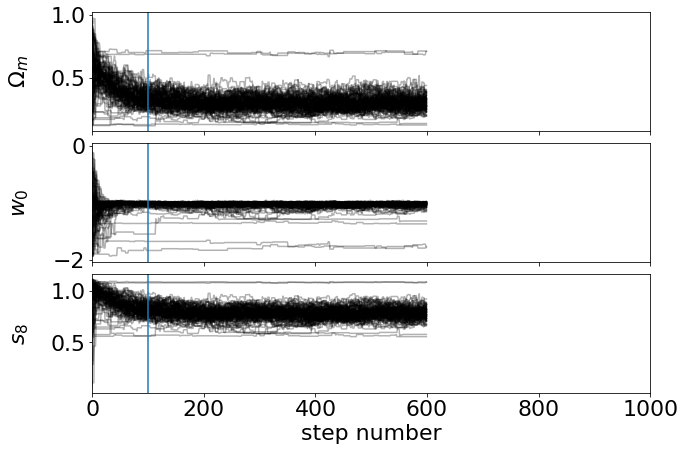

In [198]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
good_walkers = sampler.acceptance_fraction > 0
bad_samples = sampler.get_chain()[:,good_walkers,:]
bad_blobs = sampler.get_blobs()

labels = ['$\Omega_m$', '$w_0$','$s_8$']
for i in range(ndims+1): #+1 for blobs
    ax = axes[i]
    dat = bad_blobs["s_8"][:1000,good_walkers] if i==2 else bad_samples[:1000,:,i]
    ax.plot(dat, 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)
    ax.axvline(Nburnin)
    
axes[-1].set_xlabel('step number')
fig.tight_layout()

In [199]:
#Results from the 2D notebook to compare with
#global/homes/h/hrincon/mcmc2/w0/0.25/og_modded_s8/bgrid_z0.25_final.npy
bgrid_og = np.load("./0.25/true_og/bgrid_z0.25_final.npy")

In [200]:
import pickle
with open("./0.25/true_og/samples.pickle", 'rb') as temp_outfile:
    samples_og = pickle.load(temp_outfile)

Removed no burn in


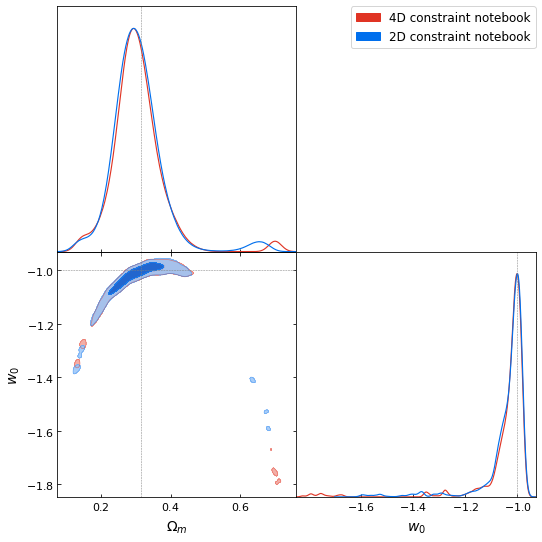

In [201]:
#newresutlswith relaxed sigma8
names = ["Omega_m","w_0"]
labels =  ["\Omega_m","w_0"]
samples = MCSamples(samples=(postsamples),names = names, labels = labels)
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([samples,samples_og], 
                markers=[0.315,-1],
                filled=True,
                legend_labels=["4D constraint notebook","2D constraint notebook"])
plt.show()

Removed no burn in


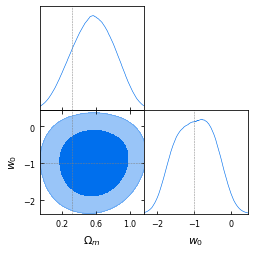

In [28]:
#old (inaccurate) resutls with fixed sigma8
# plot the results
names = ["Omega_m","w_0"]
labels =  ["\Omega_m","w_0"]
samples = MCSamples(samples=(postsamples[:,::2]),names = names, labels = labels)
g = plots.get_subplot_plotter()
g.triangle_plot([samples], markers=[0.315,-1],filled=True)
plt.show()